  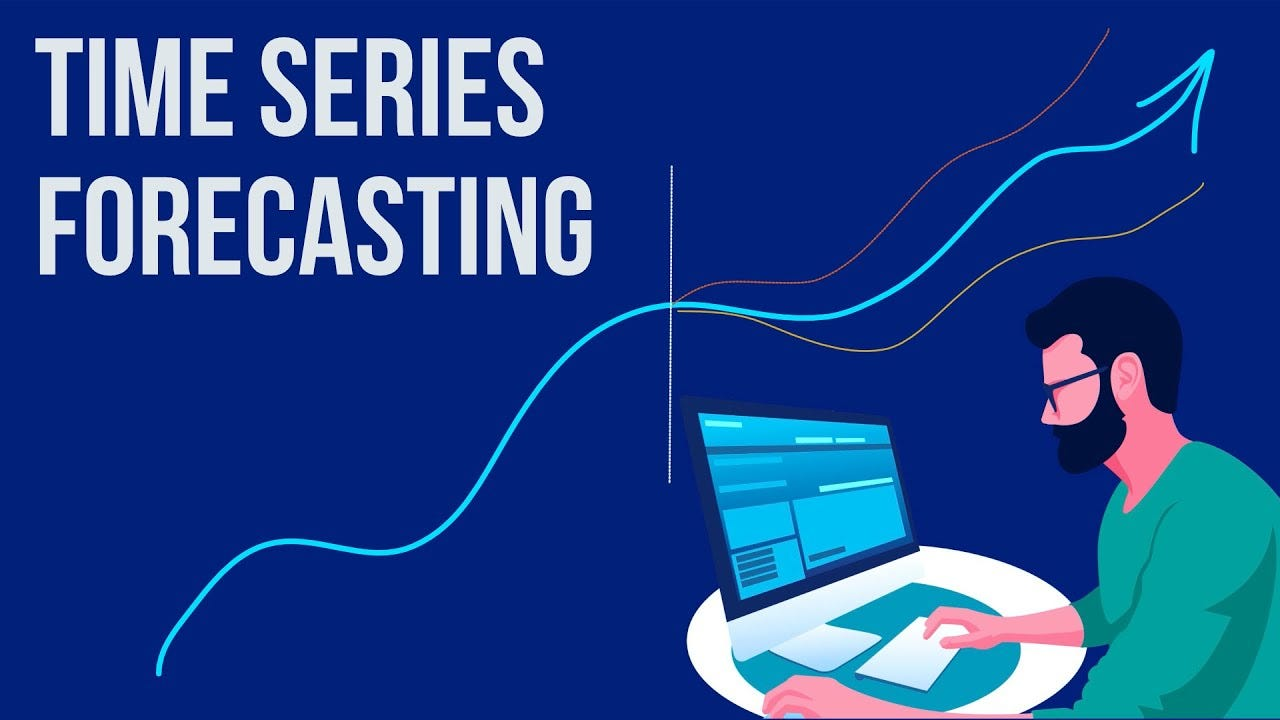

## INTRODUCTION

In this project we are given few datapoints related to sales numbers for a retail store. We will first do some exploratory data analysis and after that we will attempt to forecast the store's sales numbers for the next 12 months using 3 different forecasting models. We will use Exponential Smoothing(Holt-Winters additive), SARIMA and Prophet to fit and forecast. I will ty to explain each model in detail so hopefully you will find this notebook informative.

In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

## Data Imports and Analysis

In [65]:
df = pd.read_csv('/kaggle/input/sales-forecasting/train.csv')

In [66]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94


We see there is missing data under zipcode. We will not be using this column so we wont bother with imputation.

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

Grouping to understand some of the categorical fields.

In [68]:
df['Segment'].value_counts()

Segment
Consumer       5101
Corporate      2953
Home Office    1746
Name: count, dtype: int64

In [69]:
df['Region'].value_counts()

Region
West       3140
East       2785
Central    2277
South      1598
Name: count, dtype: int64

In [70]:
df['Category'].value_counts()

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64

In [71]:
df['Sub-Category'].value_counts()

Sub-Category
Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: count, dtype: int64

In [72]:
df['Ship Mode'].value_counts()

Ship Mode
Standard Class    5859
Second Class      1902
First Class       1501
Same Day           538
Name: count, dtype: int64

## Exploratory Data Analysis

Plotting sales on US map using choropleth and Plotly. We create a dictionary of the stae codes to achieve this since neither state codes nor long/lat data is available. Map is intercative so hovering over the state will show you details.

In [74]:
!pip install plotly

In [75]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize Plotly in Jupyter Notebook mode
import plotly.io as pio
pio.renderers.default = 'notebook_connected'


# Create a mapping for all 50 states 
all_state_mapping = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL",
    "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
    "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT",
    "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Add the Abbreviation column to the DataFrame
df['Abbreviation'] = df['State'].map(all_state_mapping)

# Group by state and calculate the sum of sales
sum_of_sales = df.groupby('State')['Sales'].sum().reset_index()

# Add Abbreviation to sum_of_sales
sum_of_sales['Abbreviation'] = sum_of_sales['State'].map(all_state_mapping)

# Create a choropleth map using Plotly
fig = go.Figure(data=go.Choropleth(
    locations=sum_of_sales['Abbreviation'],
    locationmode='USA-states',
    z=sum_of_sales['Sales'],
    hoverinfo='location+z',
    showscale=True
))

fig.update_geos(projection_type="albers usa")
fig.update_layout(
    geo_scope='usa',
    title='Total Sales by U.S. State'
)

fig.show()

Another view of sales by State on a horizontal bar graph. We see States like CA, NY and TX have teh most sales.

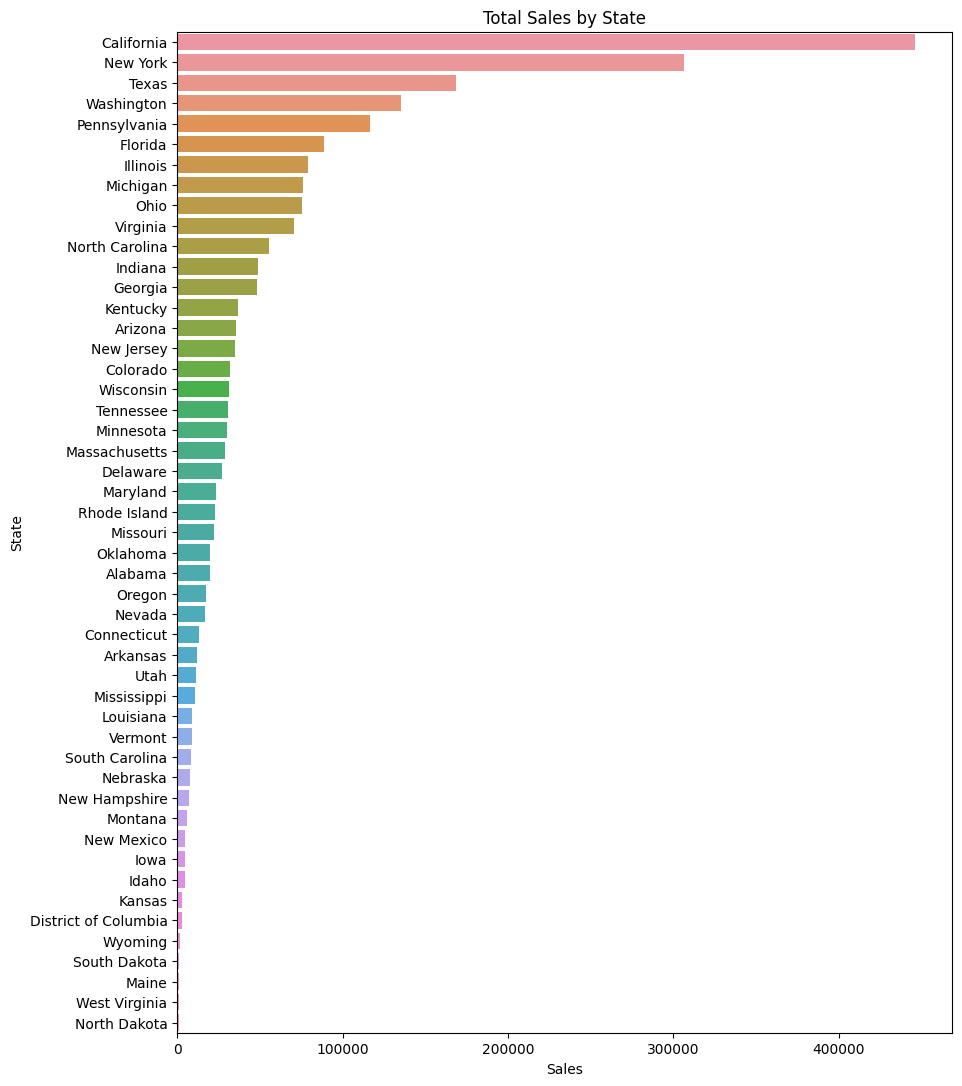

In [76]:
# Group by state and calculate the sum of sales
sum_of_sales = df.groupby('State')['Sales'].sum().reset_index()

# Sort the DataFrame by the 'Sales' column in descending order
sum_of_sales = sum_of_sales.sort_values(by='Sales', ascending=False)

# Create a horizontal bar graph
plt.figure(figsize=(10, 13))
ax = sns.barplot(x='Sales', y='State', data=sum_of_sales, ci=None)

plt.xlabel('Sales')
plt.ylabel('State')
plt.title('Total Sales by State')
plt.show()


Visualizing some of the other categorical columns

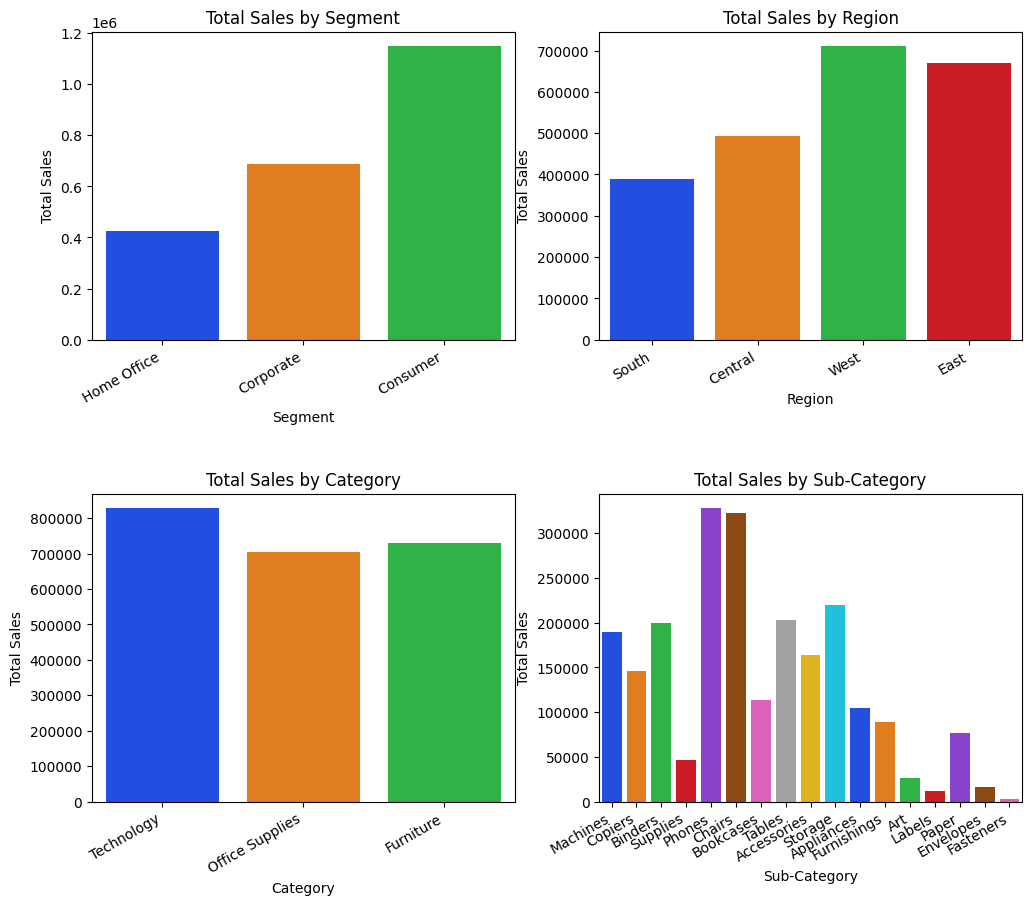

In [77]:
# Sort the DataFrame by 'Sales' in descending order
df = df.sort_values(by='Sales', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5)

# List of columns to plot
columns = ['Segment', 'Region', 'Category', 'Sub-Category']

# Create barplots for each column
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.barplot(x=column, y='Sales', data=df, estimator=np.sum, errorbar=None, palette='bright', ax=ax)
    ax.set_ylabel('Total Sales')
    ax.set_title(f'Total Sales by {column}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# Display the plots
plt.show()

Here is a nested pie chart(sunburst) showing linkage between Category and Subcategory using plotly. Chart is interactive so hovering over will give you details.Click/unclick on the Categories to see how chart details change.

In [78]:
import plotly.express as px
# Summarize the Sales data by Category and Sub-Category
df_summary = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().reset_index()
# Create a nested pie chart
fig = px.sunburst(
    df_summary,
    path=['Category', 'Sub-Category'],
    values='Sales',
)

fig.show()

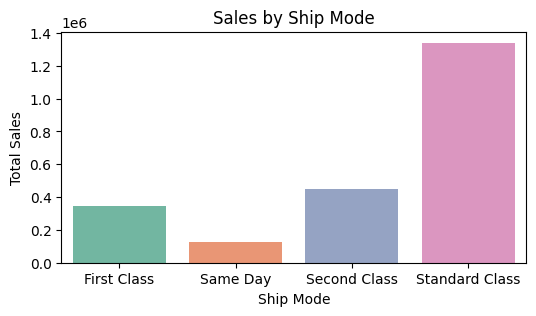

In [79]:
# Group by "Ship Mode" and calculate the sum of sales
sales_by_ship_mode = df.groupby("Ship Mode")["Sales"].sum().reset_index()

# Set a color palette
colors = sns.color_palette("Set2")

# Create a bar plot with different colors
plt.figure(figsize=(6, 3))
sns.barplot(x="Ship Mode", y="Sales", data=sales_by_ship_mode, palette=colors)
plt.xlabel("Ship Mode")
plt.ylabel("Total Sales")
plt.title("Sales by Ship Mode")
plt.show()

This is a treemap that shows the linkage between Shipping Mode, Category and Sub Category. Interactive.

In [80]:
# Summarize the Sales data by Category, Ship Mode, and Sub-Category
df_summary = df.groupby(['Category', 'Ship Mode', 'Sub-Category'])['Sales'].sum().reset_index()

# Create a treemap
fig = px.treemap(
    df_summary,
    path=['Category', 'Ship Mode', 'Sub-Category'],
    values='Sales',
)

fig.show()

We will create few more columns splitting the Order Date column.

In [81]:
# Convert the "Order Date" column to a datetime format with "dd/mm/yyyy" format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')

# Extract day, month, and year into separate columns
df['Day'] = df['Order Date'].dt.day
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year

# Print the modified DataFrame
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Abbreviation,Day,Month,Year
2697,2698,CA-2015-145317,2015-03-18,23/03/2015,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,...,South,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.48,FL,18,3,2015
6826,6827,CA-2017-118689,2017-10-02,09/10/2017,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,Central,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.95,IN,2,10,2017


Daily Sales view will be too crowded so we are summarizing into a monthly view to see Sales trends.

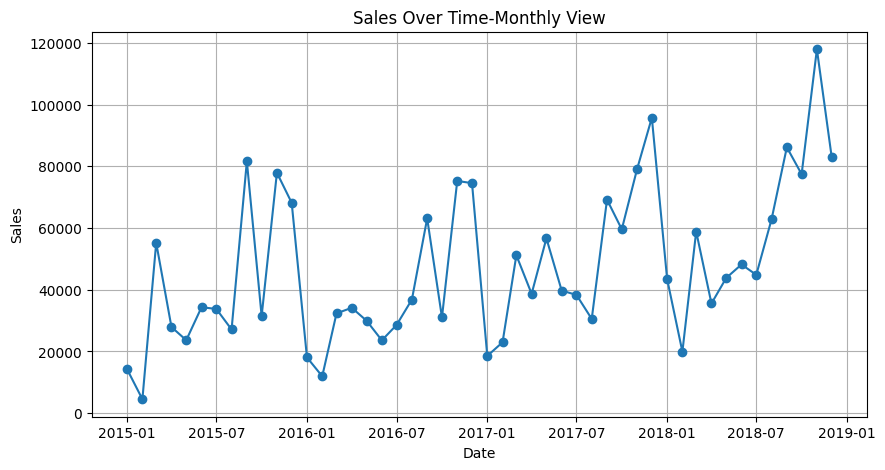

In [82]:
# Combine "Month" and "Year" into a datetime column
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')

# Group by the combined date and calculate the sum of sales
df_summary = df.groupby('Date')['Sales'].sum().reset_index()

# Create a line plot
plt.figure(figsize=(10, 5))
plt.plot(df_summary['Date'], df_summary['Sales'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time-Monthly View')
plt.grid(True)
plt.show()


Below is the daily view, we can see some outliers but that should not tinker with our forecast too much.

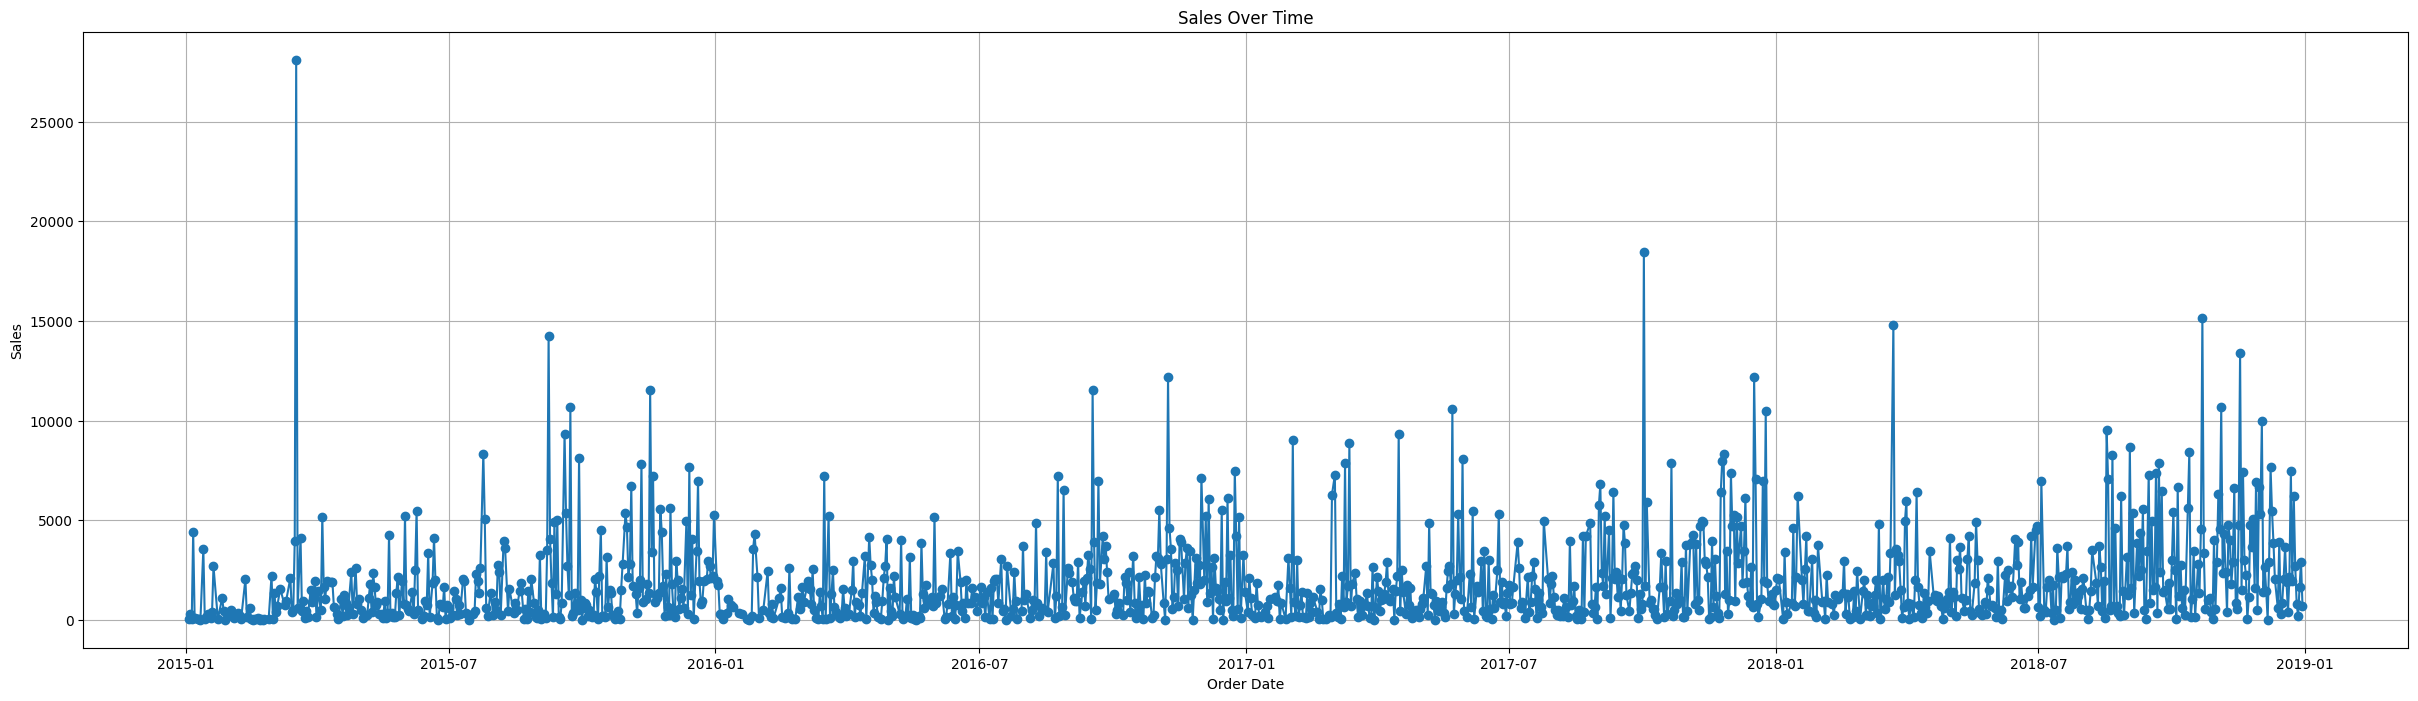

In [83]:
# Group by "Order Date" and calculate the sum of sales
df_summary = df.groupby('Order Date')['Sales'].sum().reset_index()

# Create a line plot
plt.figure(figsize=(30, 8))
plt.plot(df_summary['Order Date'], df_summary['Sales'], marker='o', linestyle='-')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.grid(True)
plt.show()

In [84]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Abbreviation,Day,Month,Year,Date
2697,2698,CA-2015-145317,2015-03-18,23/03/2015,Standard Class,SM-20320,Sean Miller,Home Office,United States,Jacksonville,...,TEC-MA-10002412,Technology,Machines,Cisco TelePresence System EX90 Videoconferenci...,22638.48,FL,18,3,2015,2015-03-01
6826,6827,CA-2017-118689,2017-10-02,09/10/2017,Standard Class,TC-20980,Tamara Chand,Corporate,United States,Lafayette,...,TEC-CO-10004722,Technology,Copiers,Canon imageCLASS 2200 Advanced Copier,17499.95,IN,2,10,2017,2017-10-01


We need to check if there are any missing dates on the daily trends and populate those dates with 0 sales to ensure proper decomposition on the daily view. Also, some models will not work well if the date trend is not consistent.

In [85]:
# Convert "Order Date" to a datetime column
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

# Generate a date range from the minimum to the maximum date
date_range = pd.date_range(start=df['Order Date'].min(), end=df['Order Date'].max())

# Find missing dates by comparing the date range with the unique dates in the "Order Date" column
missing_dates = date_range[~date_range.isin(df['Order Date'])]

# Count the total number of missing dates
total_missing_dates = len(missing_dates)

# Display the list of missing dates and the total count
#print("Missing Dates:")
#for date in missing_dates:
 #   print(date.strftime('%m/%d/%Y'))
print(f"Total Missing Dates: {total_missing_dates}")

Total Missing Dates: 228


Populate missing dates and append to the dataset

In [86]:
# Convert "Order Date" to a datetime column
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

# Define the date range
date_range = pd.date_range(start=df['Order Date'].min(), end=df['Order Date'].max())

# Find missing dates
missing_dates = date_range.difference(df['Order Date'])

# Add missing dates to the DataFrame with Sales number of 0
missing_data = {
    "Order Date": missing_dates,
    "Sales": [0] * len(missing_dates)
}
missing_df = pd.DataFrame(missing_data)

# Concatenate the missing data with the original DataFrame
df = pd.concat([df, missing_df], ignore_index=True)

# Sort the DataFrame by "Order Date"
df = df.sort_values(by='Order Date')

df.head(2)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Abbreviation,Day,Month,Year,Date
7436,7981.0,CA-2015-103800,2015-01-03,07/01/2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,TX,3.0,1.0,2015.0,2015-01-01
8153,740.0,CA-2015-112326,2015-01-04,08/01/2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,IL,4.0,1.0,2015.0,2015-01-01


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10028 entries, 7436 to 6943
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   float64       
 1   Order ID       9800 non-null   object        
 2   Order Date     10028 non-null  datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 no

In [88]:
# Convert "Order Date" to a datetime column
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

# Extract the "Day," "Month," and "Year" from the "Order Date" column
df['Day'] = df['Order Date'].dt.day
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year

df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Abbreviation,Day,Month,Year,Date
7436,7981.0,CA-2015-103800,2015-01-03,07/01/2015,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,TX,3,1,2015,2015-01-01
8153,740.0,CA-2015-112326,2015-01-04,08/01/2015,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,IL,4,1,2015,2015-01-01


## Decomposition

Lets look at the daily and monthy data decomposition for trends and seasonality. We can immediatey see the the trend is upward and heavy seasonality exists.

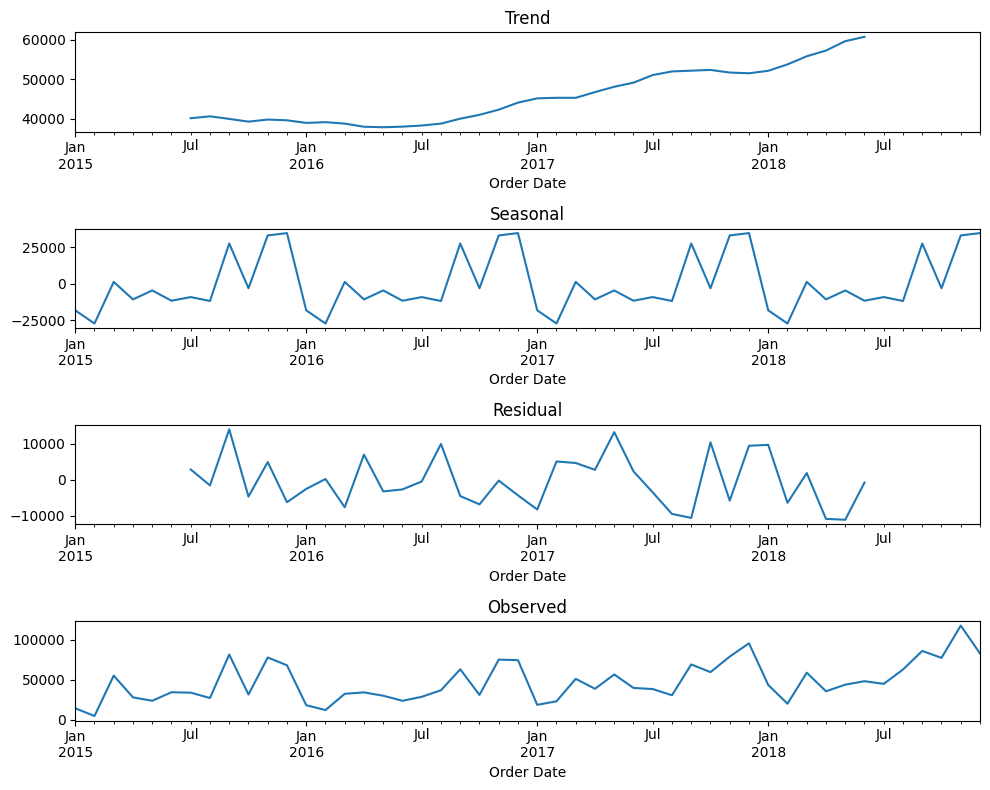

In [89]:
import statsmodels.api as sm

# Create a copy of the DataFrame to preserve the original "Order Date" column
df_copy = df.copy()

# Ensure 'Order Date' is in datetime format in the copy
df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])

# Set 'Order Date' as the index in the copy
df_copy.set_index('Order Date', inplace=True)

# Resample the data to monthly frequency and sum the sales for each month in the copy
df_monthly = df_copy['Sales'].resample('M').sum()

# Decompose the time series into monthly components
decomposition_monthly = sm.tsa.seasonal_decompose(df_monthly, model='additive')

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
decomposition_monthly.trend.plot(ax=axes[0])
axes[0].set_title('Trend')
decomposition_monthly.seasonal.plot(ax=axes[1])
axes[1].set_title('Seasonal')
decomposition_monthly.resid.plot(ax=axes[2])
axes[2].set_title('Residual')
decomposition_monthly.observed.plot(ax=axes[3])
axes[3].set_title('Observed')

plt.tight_layout()
plt.show()


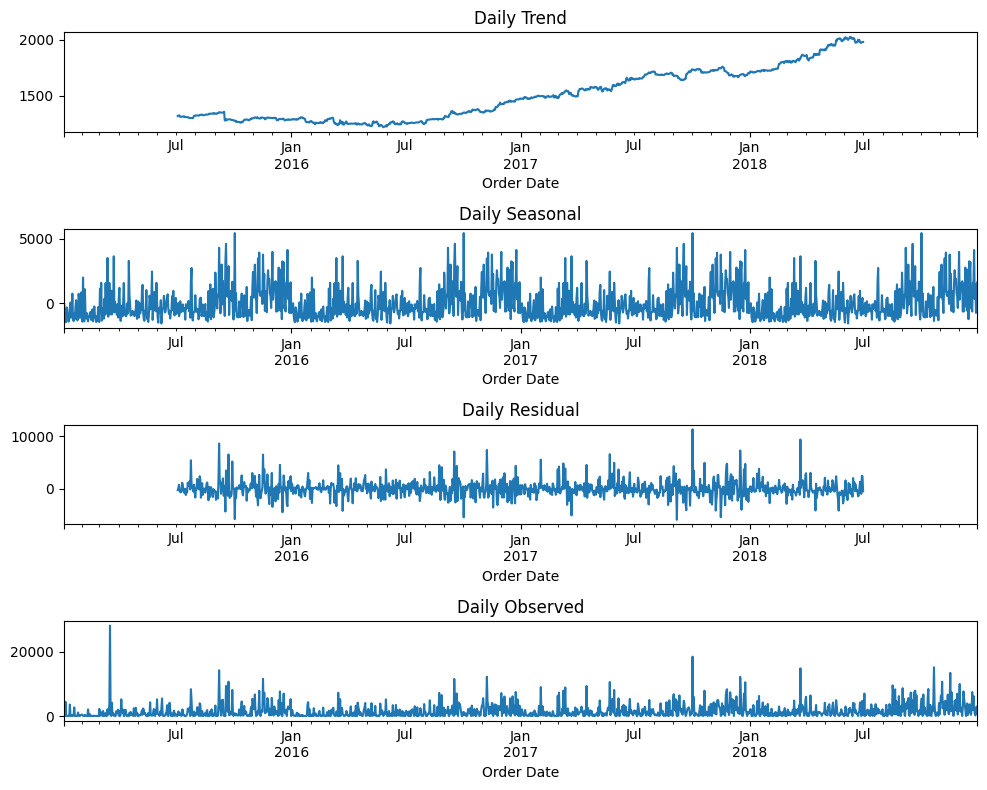

In [90]:
import statsmodels.api as sm

# Create a copy of the DataFrame to preserve the original "Order Date" column
df_copy = df.copy()

# Ensure 'Order Date' is in datetime format in the copy
df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])

# Set 'Order Date' as the index in the copy
df_copy.set_index('Order Date', inplace=True)

# Resample the data to daily frequency and sum the sales for each day in the copy
df_daily = df_copy['Sales'].resample('D').sum()

# Decompose the time series into daily components
decomposition_daily = sm.tsa.seasonal_decompose(df_daily, model='additive',period=365)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 8))
decomposition_daily.trend.plot(ax=axes[0])
axes[0].set_title('Daily Trend')
decomposition_daily.seasonal.plot(ax=axes[1])
axes[1].set_title('Daily Seasonal')
decomposition_daily.resid.plot(ax=axes[2])
axes[2].set_title('Daily Residual')
decomposition_daily.observed.plot(ax=axes[3])
axes[3].set_title('Daily Observed')

plt.tight_layout()
plt.show()


## ACF/PACF Plots

Autocorrelation (ACF) and partial autocorrelation (PACF) plots are commonly used in time series analysis to understand the temporal dependencies within a dataset. These plots help us identify the order of autoregressive (AR) and moving average (MA) components when fitting time series models like ARIMA and SARIMA.

    The ACF plot helps you understand the correlation between an observation and lagged versions of itself. Each point on the ACF plot represents the correlation between the series at time "t" and the series at a previous time "t - k," where "k" is the lag. A sharp drop-off in the ACF plot suggests that the data doesn't have a long memory, while a slow decay may indicate a trend or seasonality.

    In the context of ARIMA modeling, the ACF plot is used to determine the order of the MA component. Specifically, if the ACF plot exhibits a sharp drop after a certain lag ("q"), it suggests that an MA(q) term should be included in the model.

    The PACF plot helps you understand the direct relationship between an observation and its past values while removing the correlation due to other lags. Each point on the PACF plot represents the partial correlation between the series at time "t" and the series at time "t - k" while controlling for the influence of the lags between "t" and "t - k."

    In ARIMA modeling, the PACF plot is used to determine the order of the AR component. If the PACF plot exhibits a sharp drop after a certain lag ("p"), it suggests that an AR(p) term should be included in the model.

In summary, ACF and PACF plots help you identify the orders of AR and MA components by analyzing the correlation and partial correlation between the time series and its past values at different lags. These plots are essential for model selection and diagnostic purposes in time series analysis.

Spikes on lag 0 and 12 point to seasonality every 12 cycles which can also be observed from the decomposition plots.

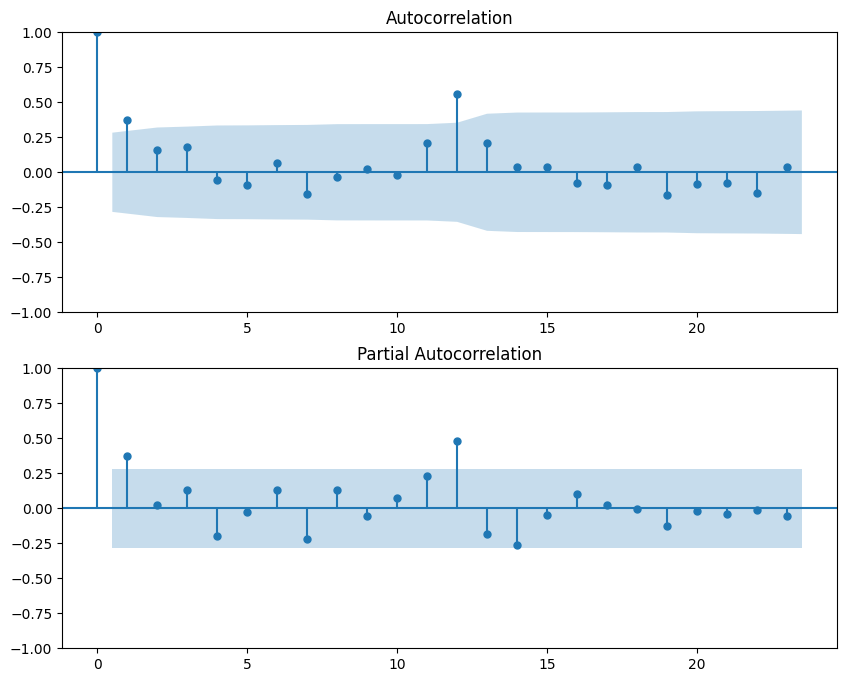

In [91]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a copy of the DataFrame to preserve the original data
df_copy = df.copy()

# Convert the 'Order Date' column to datetime and set it as the index in the copy
df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])
df_copy.set_index('Order Date', inplace=True)

# Resample the data to monthly frequency and sum the sales for each month in the copy
df_monthly = df_copy['Sales'].resample('M').sum()

# Create ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df_monthly, lags=23, ax=ax1)
plot_pacf(df_monthly, lags=23, ax=ax2)

plt.show()

## Checking stationarity on time series

Augmented Dickey-Fuller (ADF) Test: The ADF test is a statistical test for stationarity. It tests the null hypothesis that a unit root is present in a time series sample. If the p-value from the test is less than a significance level (e.g., 0.05), you can reject the null hypothesis and consider the data stationary.

In time series analysis, stationary data is a fundamental concept. A time series is considered stationary when statistical properties such as the mean, variance, and autocorrelation do not change over time. Here's what it means:

Constant Mean: The mean (average) of the time series data remains constant over time. In other words, the data does not exhibit any significant upward or downward trend.

Constant Variance: The variance (spread or variability) of the data remains constant over time. The data points are equally dispersed around the mean.

Constant Autocorrelation: The autocorrelation, which measures the relationship between data points at different time lags, is constant. This means that the correlation structure does not change with time.

Stationary data is desirable in time series analysis because many statistical methods and models assume stationarity. These models may not perform well on non-stationary data, and the results can be unreliable. Therefore, if a time series is non-stationary, it is often transformed or differenced to achieve stationarity.

There are two types of stationarity:

Strict Stationarity: This is a stronger form of stationarity where the joint probability distribution of the data remains the same regardless of time shifts. All statistical properties, including moments and autocorrelations, are constant.

Trend-Stationarity (Weak Stationarity): In practice, most time series data are not strictly stationary due to external factors. In trend-stationarity, the data may contain a deterministic trend, but the statistical properties of the residuals (after removing the trend) are stationary.

In [92]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'])
p_value = result[1]

if p_value <= 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")


Data is stationary


## Preprocessing and Modelling

In [93]:
df_copy = df[['Order Date', 'Sales']].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10028 entries, 7436 to 6943
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  10028 non-null  datetime64[ns]
 1   Sales       10028 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 235.0 KB


## Modelling with Holt-Winters(Additive Exponential Smoothing)

The Holt-Winters model, also known as the Triple Exponential Smoothing model, is an extension of the Holt's Linear Exponential Smoothing model with the added capability of handling seasonality. It is a powerful and widely used time series forecasting method that is particularly useful for data with both trend and seasonality components. The Holt-Winters model provides forecasts by taking into account three main components:

1. **Level (L)**: The level component represents the average value of the time series data. It acts as a baseline around which the data fluctuates.

2. **Trend (T)**: The trend component captures the overall direction and long-term movement in the data. It accounts for the systematic increase or decrease in the series over time.

3. **Seasonality (S)**: The seasonality component handles periodic fluctuations or patterns that repeat at regular intervals, such as daily, weekly, or monthly.

The Holt-Winters model is classified into two main variations:

1. **Additive Seasonal Holt-Winters (AHW)**:
    - In this variation, seasonality is added to the series as a fixed value, and it is usually combined with the level and trend additively.
    - The equation for forecasting in the additive model is:
      `Forecast for next period = (L + T) + S`
    - The model parameters include smoothing factors (alpha, beta, gamma) for level, trend, and seasonality.

2. **Multiplicative Seasonal Holt-Winters (MHW)**:
    - In this variation, seasonality is treated as a percentage or multiplier, and it is multiplied with the level and trend.
    - The equation for forecasting in the multiplicative model is:
      `Forecast for next period = (L * T) * S`
    - The model parameters also include smoothing factors (alpha, beta, gamma) for level, trend, and seasonality.

**Model Selection:**
- You choose between additive and multiplicative Holt-Winters models based on the nature of the seasonality in your data. If the seasonal component appears to grow proportionally with the level and trend, then the multiplicative model is appropriate. If the seasonal component is relatively constant and does not depend on the level or trend, the additive model is more suitable.

**Parameter Estimation:**
- The smoothing factors (alpha, beta, and gamma) are estimated from the data through optimization techniques to minimize the forecast error. The choice of these smoothing parameters plays a significant role in model performance.
- The choice of the seasonality period (e.g., monthly or weekly seasonality) is important for the model to capture the underlying patterns.

**Forecasting:**
- The Holt-Winters model combines the level, trend, and seasonality components to provide forecasts for future data points.
- The model is updated with each new observation to adapt to changes in the time series.

Holt-Winters models are widely used in various domains, including economics, finance, sales forecasting, and supply chain management. They are effective for capturing both short-term and long-term trends, as well as seasonality in time series data.

Important Hyperparameters:

Alpha (α): This is the smoothing parameter for the level component. It controls the weight given to the most recent observation when updating the estimated level. A lower value of alpha (e.g., 0.2) gives less weight to recent observations, making the model more resistant to short-term fluctuations.

Beta (β): Beta is the smoothing parameter for the trend component. It controls the weight given to the most recent estimated trend when updating the trend. Similar to alpha, a lower value of beta (e.g., 0.2) gives less weight to recent estimated trends.

Gamma (γ): Gamma is the smoothing parameter for the seasonal component. It controls the weight given to the most recent seasonal component when updating the seasonal effect. A moderate value of gamma (e.g., 0.3) is often used to balance the impact of seasonality.

Damped: The damped option controls whether the trend component should be damped. A damped trend gradually reduces the amplitude of the estimated trend over time. This can be helpful when you expect the trend to decrease or dampen as you move further into the future. Enabling damping by setting it to True can help prevent overly optimistic long-term forecasts.

Other hyperparameters might include:

Seasonal Type: You can specify the type of seasonality as 'add' (default) or 'multiplicative' based on the nature of your data. 'Add' is used when the seasonal component has a consistent absolute effect on the data, while 'multiplicative' is used when the seasonal component has a consistent proportional effect.

Seasonal Periods: The number of seasons in a year. For example, if you are working with monthly data, the seasonal period would typically be 12 (for 12 months in a year).

Trend Type: You can specify the type of trend as 'add' (default) or 'multiplicative' based on the nature of the trend in your data.

Seasonal Smoothing Type: For more advanced models, you can specify whether the seasonal component is additive or multiplicative.

## Fine Tuning Holt Winters

Methods like GridSearch/RandomSeach etc are not compatible with statsmodel library of Python so we establish a typical loop to go thru the parameters and identify what works best. We also do the data split. We wil be training and fitting using the best hyperparameters, using the test data to forecast and then we will do an out of sample forecast for the next 12 months. We do the fine tuning on train data to avoid data leakage.

In [94]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

# Assuming you have a DataFrame df_copy with 'Order Date' and 'Sales' columns
# Make sure the 'Order Date' column is in datetime format
df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])

# Set 'Order Date' as the index
df_copy.set_index('Order Date', inplace=True)

# Resample the data to monthly frequency and sum the sales for each month
df_monthly = df_copy['Sales'].resample('M').sum()

# Split the data into training and test sets (80/20 split)
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly[:train_size], df_monthly[train_size:]

param_grid = {
    'seasonal': ['add', 'multiplicative'],
    'seasonal_periods': [12],
    'trend': ['add', 'additive', 'multiplicative'],
    'smoothing_level': [0.1, 0.2, 0.3, 0.4, 0.5],
    'smoothing_trend': [0.1, 0.2, 0.3, 0.4, 0.5],
    'smoothing_seasonal': [0.1, 0.2, 0.3, 0.4, 0.5],
    'damping_trend': [0.1, 0.2, 0.3, 0.4, 0.5],
}

best_model = None
best_mse = float('inf')

total_iterations = len(param_grid['seasonal']) * len(param_grid['seasonal_periods']) * len(param_grid['trend']) * \
                   len(param_grid['smoothing_level']) * \
                   len(param_grid['smoothing_trend']) * len(param_grid['smoothing_seasonal']) * len(param_grid['damping_trend'])

iteration = 0

# Perform a grid search by iterating over hyperparameters
for seasonal in param_grid['seasonal']:
    for seasonal_period in param_grid['seasonal_periods']:
        for trend in param_grid['trend']:
                for smoothing_level in param_grid['smoothing_level']:
                        for smoothing_trend in param_grid['smoothing_trend']:
                            for smoothing_seasonal in param_grid['smoothing_seasonal']:
                                for damping_trend in param_grid['damping_trend']:
                                    iteration += 1

                                    model = ExponentialSmoothing(
                                        train, seasonal=seasonal, seasonal_periods=seasonal_period, trend=trend
                
                                    )
                                    model_fit = model.fit(
                                        smoothing_level=smoothing_level,
                                        smoothing_trend=smoothing_trend, smoothing_seasonal=smoothing_seasonal,
                                        damping_slope=damping_trend
                                    )
                                    forecast = model_fit.forecast(steps=len(test))
                                    mse = np.mean((test - forecast) ** 2)

                                    # Check if this model has a lower MSE than the best found so far
                                    if mse < best_mse:
                                        best_mse = mse
                                        best_model = model_fit

                                    #print(f"Iteration {iteration}/{total_iterations} - Best MSE: {best_mse:.4f}")

# The best model and its hyperparameters
print("Best Model Hyperparameters:")
print("Seasonal:", best_model.model.seasonal)
print("Seasonal Periods:", best_model.model.seasonal_periods)
print("Trend:", best_model.model.trend)
print("Smoothing Level(alpha):", best_model.params['smoothing_level'])
print("Smoothing Trend(beta):", best_model.params['smoothing_trend'])
print("Smoothing Seasonal(gamma):", best_model.params['smoothing_seasonal'])
print("Damping Trend:", best_model.params['damping_trend'])


Best Model Hyperparameters:
Seasonal: add
Seasonal Periods: 12
Trend: add
Smoothing Level(alpha): 0.1
Smoothing Trend(beta): 0.2
Smoothing Seasonal(gamma): 0.1
Damping Trend: nan


We now set up the model using the best hyperparameters and score using r2. We also plot actual, fitted, test(forecast) and out of sample(extended forecast) on a graph.

R-squared score for test set: 0.74
R-squared score for training (fitted) set: 0.87


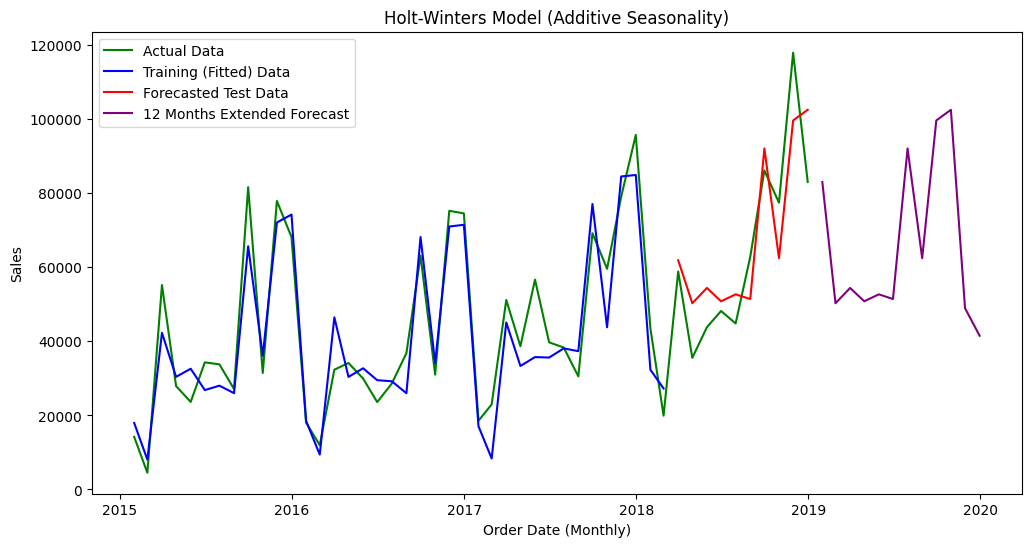

In [95]:
# Best hyperparameters defined after fine tuning
alpha = 0.1  # Smoothing parameter for the level component
beta = 0.2   # Smoothing parameter for the trend component
gamma = 0.1  # Smoothing parameter for the seasonal component
damped = False  # Whether the trend component should be damped

# Initialize the ExponentialSmoothing model with hyperparameters
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12, trend='add', damped=damped)

# Fit the model with the specified hyperparameters
model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

# Make out-of-sample forecasts for the test set
forecast = model_fit.forecast(steps=len(test))

# Create an index for the forecasted data starting right after training data
forecast.index = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=len(test), freq='M')

# Extend the index for a 12-month forecast after the test data
forecast_extended = pd.date_range(start=test.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast = pd.concat([forecast, pd.Series(data=np.nan, index=forecast_extended)])

# Calculate R-squared score for the test data
r2_test = 1 - np.sum((test - forecast[:len(test)]) ** 2) / np.sum((test - np.mean(test)) ** 2)
print(f"R-squared score for test set: {r2_test:.2f}")

# Calculate R-squared score for the training (fitted) data
fitted = model_fit.fittedvalues  # Fitted values for training data
r2_train = 1 - np.sum((train - fitted) ** 2) / np.sum((train - np.mean(train)) ** 2)
print(f"R-squared score for training (fitted) set: {r2_train:.2f}")

# Plot the actual data, training (fitted) data, and forecasted values with different colors
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly, label='Actual Data', color='green')
plt.plot(train.index, fitted, label='Training (Fitted) Data', color='blue')
plt.plot(forecast.index, forecast, label='Forecasted Test Data', color='red')

# Get the last value of the test data
last_test_value = test[-1]

# Extend the forecast for an additional 12 months after the test data ends
forecast_extended = model_fit.forecast(steps=12)
forecast_extended.index = pd.date_range(start=test.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Set the first value of the extended forecast to be the last value of the test data
forecast_extended.iloc[0] = last_test_value

plt.plot(forecast_extended.index, forecast_extended, label='12 Months Extended Forecast', color='purple')

plt.legend()
plt.xlabel('Order Date (Monthly)')
plt.ylabel('Sales')
plt.title('Holt-Winters Model (Additive Seasonality)')
plt.show()



## Modelling with SARIMA

In [96]:
df_copy = df[['Order Date', 'Sales']].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10028 entries, 7436 to 6943
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  10028 non-null  datetime64[ns]
 1   Sales       10028 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 235.0 KB


Preprocessing the data to get it ready for fine tuning using auto_arima

In [97]:
# Aggregate daily sales
time_sales = df_copy.groupby("Order Date").sum()
time_sales.head(2)

,Sales
Order Date,
2015-01-03,16.448
2015-01-04,288.060


In [98]:
# reset the index
time_sales1 = time_sales.copy()
time_sales1.reset_index(inplace=True)

In [99]:
# Resample the data on 'Sales' price monthly
sale_monthly = time_sales1.resample('M', on='Order Date').mean()
sale_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2015-01-31 to 2018-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


Plot to ensure data is aggregated properly

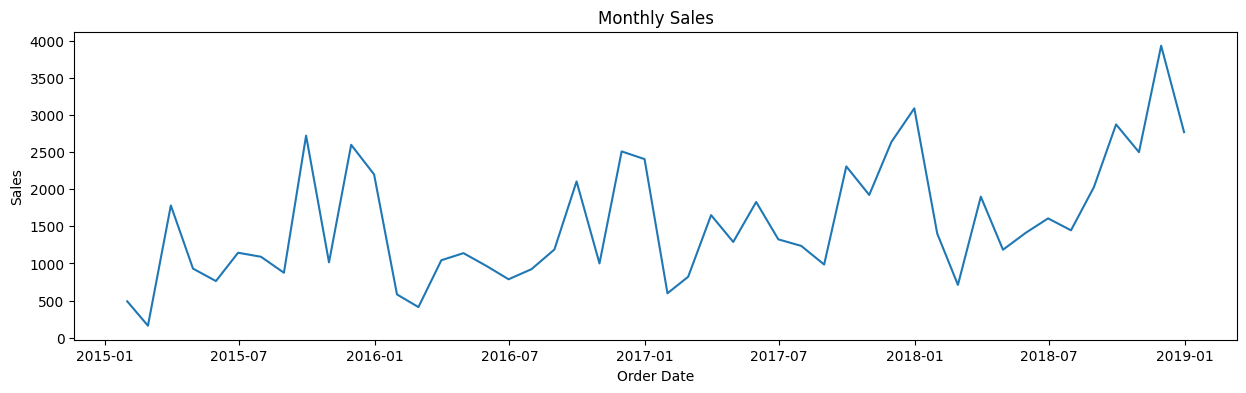

In [100]:
plt.figure(figsize=(15, 4))  
sns.lineplot(x='Order Date', y='Sales', data=sale_monthly)
plt.title('Monthly Sales')
plt.show()

In [101]:
!pip install pmdarima

Seasonal Autoregressive Integrated Moving Average (SARIMA) is a time series forecasting model that extends the capabilities of the Autoregressive Integrated Moving Average (ARIMA) model to account for both seasonality and non-seasonal components in time series data. SARIMA is a powerful method for modeling and forecasting time series data that exhibit both trend and seasonal patterns.

The SARIMA model is defined by three main components:

1. **Seasonal Component (S)**: SARIMA accounts for seasonality, which is a repeating pattern that occurs at regular intervals (e.g., daily, weekly, or monthly). The seasonal component is represented by three parameters:
    - **P (Seasonal Autoregressive Order)**: This parameter indicates the number of seasonal autoregressive terms in the model. It measures the influence of past seasonal values on the current value.
    - **D (Seasonal Difference Order)**: D represents the number of differences required to remove seasonality from the time series. It captures the order of differencing at the seasonal level.
    - **Q (Seasonal Moving Average Order)**: Q denotes the number of seasonal moving average terms in the model. It quantifies the impact of past seasonal forecast errors on the current value.

2. **Non-Seasonal Component (ARIMA)**: SARIMA includes the ARIMA model, which models the non-seasonal components of the time series data. The ARIMA component comprises the following parameters:
    - **p (Autoregressive Order)**: This parameter determines the number of autoregressive terms included in the model. It signifies the influence of past non-seasonal values on the current value.
    - **d (Difference Order)**: The order of differencing is the number of differences required to make the data stationary (i.e., have constant mean and variance). It accounts for trends in the data.
    - **q (Moving Average Order)**: q represents the number of moving average terms in the model. It measures the impact of past forecast errors on the current value.

3. **Model Order (S, D, P, D, Q)**: The combination of the seasonal and non-seasonal orders defines the SARIMA model order, often written as SARIMA(p, d, q)(P, D, Q, S), where "p" and "q" are non-seasonal AR and MA orders, and "P," "D," and "Q" are seasonal AR, seasonal difference, and seasonal MA orders. "S" denotes the seasonal period.

**Hyperparameters in SARIMA:**

1. **p (Autoregressive Order)**: The number of non-seasonal autoregressive terms.
2. **d (Difference Order)**: The number of non-seasonal differences needed to achieve stationarity.
3. **q (Moving Average Order)**: The number of non-seasonal moving average terms.
4. **P (Seasonal Autoregressive Order)**: The number of seasonal autoregressive terms.
5. **D (Seasonal Difference Order)**: The number of seasonal differences required for seasonality.
6. **Q (Seasonal Moving Average Order)**: The number of seasonal moving average terms.
7. **S (Seasonal Period)**: The seasonality period, indicating the number of time periods within one seasonal cycle (e.g., 12 for monthly data).

Hyperparameter selection in SARIMA typically involves analyzing the autocorrelation and partial autocorrelation plots of the time series data to determine the appropriate orders. It often requires experimentation and model evaluation to find the best combination of hyperparameters that provides accurate forecasts.

## Fine Tuning SARIMA

Fine Tuning SARIMA:
In the context of the `auto_arima` function from the `pmdarima` library in Python, the AIC (Akaike Information Criterion) is a statistical metric used to evaluate the goodness of fit of different ARIMA models and select the best-fitting model among several candidates. The AIC is one of the most commonly used model selection criteria.

The AIC quantifies the balance between the model's goodness of fit and its complexity, addressing the trade-off between fitting the data well and preventing overfitting. The formula for AIC is as follows:

AIC = -2 * log-likelihood + 2 * (number of model parameters)

1. **Lower AIC Value**: A lower AIC value indicates a better fit. In other words, the ARIMA model with the lowest AIC is considered the best model among the candidates.

2. **Model Complexity**: The AIC value penalizes model complexity. The penalty term, 2 * (number of model parameters), discourages overly complex models. This means that AIC prefers models that are parsimonious and use fewer parameters to explain the data.

3. **Model Selection**: `auto_arima` uses the AIC to evaluate different ARIMA model configurations automatically. It fits multiple ARIMA models with different combinations of orders (p, d, q) and seasonal orders (P, D, Q, S) and calculates the AIC for each model. It then selects the model with the lowest AIC as the best-fitting model for the given time series data.

In summary, AIC serves as a quantitative measure of model quality, considering both goodness of fit and model complexity. When using `auto_arima`, the AIC helps you choose the best ARIMA model without the need for manual selection, making it a valuable tool for time series forecasting.

In [102]:
from pmdarima import auto_arima

model_param = auto_arima(sale_monthly, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=733.692, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=775.966, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=739.454, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=774.105, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=738.692, Time=0.65 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=739.343, Time=1.50 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=737.799, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=731.933, Time=0.74

Plugging in best hyperparamaters into the model. We will fit all the data this time(you can also try splitting) and then do an out of sample forecast for the next 12 months.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11091D+01    |proj g|=  1.02042D-01

At iterate    5    f=  1.10921D+01    |proj g|=  3.67279D-03

At iterate   10    f=  1.10919D+01    |proj g|=  7.01405D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.921D-05   1.109D+01
  F =   11.091940398963642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


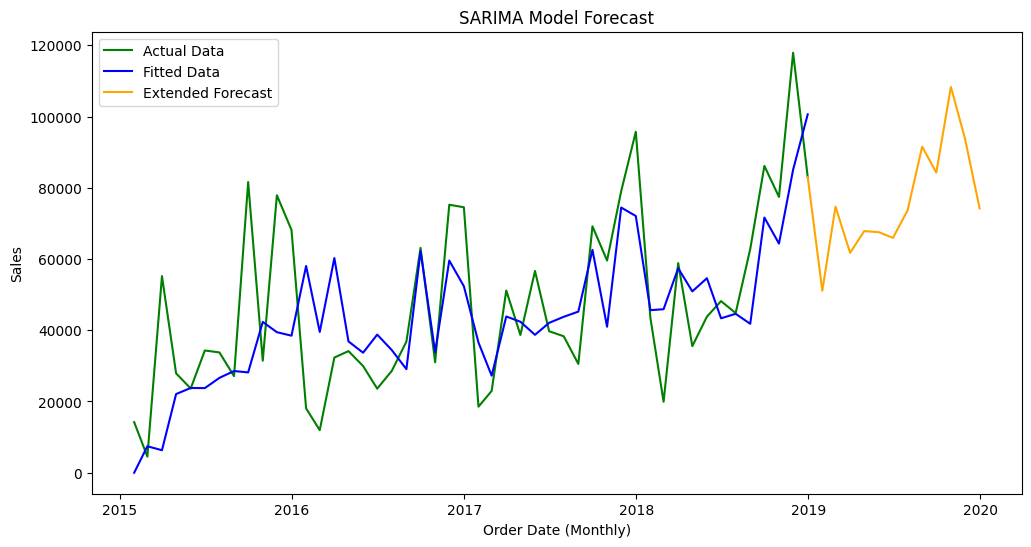

R-squared score for fitted data: 0.40


In [103]:
import statsmodels.api as sm

df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])

# Set 'Order Date' as the index
df_copy.set_index('Order Date', inplace=True)

# Resample the data to monthly frequency and sum the sales for each month
df_monthly = df_copy['Sales'].resample('M').sum()

# Define SARIMA model hyperparameters, defined after fine tuning
order = (0, 1, 1)  # (p, d, q) - Non-seasonal order
seasonal_order = (1, 0, 1, 12)  # (P, D, Q, S) - Seasonal order

#order = (0, 1, 1)  # (p, d, q) - Non-seasonal order
#seasonal_order = (2, 1, 1, 12)  # (P, D, Q, S) - Seasonal order

# Initialize the SARIMA model
sarima_model = sm.tsa.SARIMAX(df_monthly, order=order, seasonal_order=seasonal_order)

# Fit the SARIMA model to all of the actual data
sarima_model_fit = sarima_model.fit()

# Make out-of-sample forecasts for the following twelve months
forecast_extended_index = pd.date_range(start=df_monthly.index[-1], periods=13, freq='M')
forecast_extended = sarima_model_fit.get_forecast(steps=13, index=forecast_extended_index)

# Set the first value of the extended forecast to be the last value of the actual data
forecast_extended.predicted_mean[0] = df_monthly.iloc[-1]

# Calculate R-squared score for the fitted data
fitted = sarima_model_fit.fittedvalues  # Fitted values for all the actual data
r2_fitted = 1 - np.sum((df_monthly - fitted) ** 2) / np.sum((df_monthly - np.mean(df_monthly)) ** 2)

# Plot the actual data, fitted data, and extended forecast
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, df_monthly, label='Actual Data', color='green')
plt.plot(df_monthly.index, fitted, label='Fitted Data', color='blue')
plt.plot(forecast_extended_index, forecast_extended.predicted_mean, label='Extended Forecast', color='orange')

plt.legend()
plt.xlabel('Order Date (Monthly)')
plt.ylabel('Sales')
plt.title('SARIMA Model Forecast')
plt.show()

# Display R-squared score for the fitted data
print(f"R-squared score for fitted data: {r2_fitted:.2f}")


We see that model is not fitting well within the first two cycles and does a better job fitting after that. Out of sample forecast looks decent.

## Modelling with Prohpet

Prophet is a very powerful algorithm that does a great job to capture seasonality in most cases. I have achieved great results with other datasets even w/o fine tuning so we will just set this up in baseline version with all defaults.

In [104]:
df_copy = df[['Order Date', 'Sales']].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10028 entries, 7436 to 6943
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  10028 non-null  datetime64[ns]
 1   Sales       10028 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 235.0 KB


In [105]:
!pip install prophet

Prophet is an open-source forecasting tool developed by Facebook that is designed for forecasting time series data with strong seasonal patterns and multiple seasonality. It's particularly useful for working with time series data that includes holidays and other special events. Prophet was created to be user-friendly and to handle many of the challenges that arise when making time series forecasts. Here are some key aspects and features of the Prophet model:

1. **Seasonality and Holidays**: Prophet is capable of modeling both yearly and weekly seasonal patterns, as well as any special events (holidays) that might affect the time series. It allows users to provide a custom list of holidays or events and models their impact on the forecast.

2. **Flexibility**: Prophet is designed to be flexible and easy to use. It can handle time series data with missing observations and outliers, making it suitable for real-world data.

3. **Automatic Changepoint Detection**: Prophet automatically detects changepoints in the time series, which are points where the time series exhibits significant changes in its growth rate. This feature helps the model adapt to changes in trends over time.

4. **Uncertainty Estimation**: Prophet provides uncertainty intervals around the forecasted values. This allows users to assess the confidence in the forecasts and account for prediction intervals when making decisions.

5. **Linear Growth and Seasonality**: Prophet assumes that the time series has a piecewise linear growth pattern with additional seasonal components. This simplifies the model and helps it work well with various types of time series data.

6. **Holiday Effects**: Users can provide information about holidays or special events that influence the time series. Prophet models these effects and includes them in the forecasts.

7. **Custom Seasonality**: While Prophet automatically detects weekly and yearly seasonality, it also allows users to specify custom seasonality if they have domain-specific knowledge.

8. **Scalability**: Prophet is capable of handling large datasets and is designed for ease of use with minimal data preprocessing.

9. **Prophet API**: Prophet is available as a Python package with a well-documented API, making it accessible to data scientists and analysts.

Here's a basic workflow when using Prophet:

1. Prepare your time series data with a "ds" column for the date and a "y" column for the values to be forecasted.

2. Initialize a Prophet model and fit it to your historical data.

3. Optionally, provide information about holidays, special events, or custom seasonality.

4. Make forecasts using the trained model. You can generate forecasts for a specified number of periods into the future.

5. Visualize the forecasted values along with uncertainty intervals.

Prophet is especially suitable for business and financial time series data with multiple sources of seasonality and complex patterns. It has gained popularity for its ability to provide accurate and interpretable forecasts, even with minimal tuning or domain-specific knowledge.

16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing


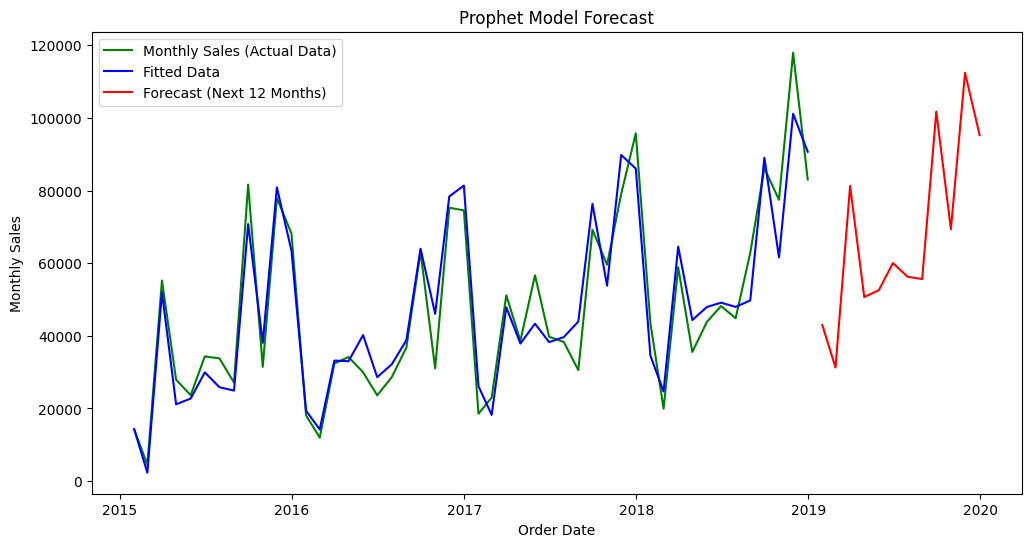

R-squared score for fitted data: 0.91


In [106]:
from prophet import Prophet

df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])

# Resample the data to monthly frequency and sum the sales for each month
monthly_data = df_copy.resample('M', on='Order Date').sum()

# Rename columns as 'ds' and 'y' as required by Prophet
monthly_data.reset_index(inplace=True)
monthly_data = monthly_data.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Initialize and fit the Prophet model
model = Prophet()
model.fit(monthly_data)

# Create a future dataframe for the next 12 months
future = model.make_future_dataframe(periods=12, freq='M')

# Make forecasts for the future
forecast = model.predict(future)

# Extract the actual data and forecast for the next 12 months
actual_data = monthly_data['y']
fitted_data = forecast['yhat'][:len(monthly_data)]  # Fitted values for the historical data
forecast_data = forecast['yhat'][len(monthly_data):]

# Calculate R-squared score for the fitted data
r2_fitted = 1 - np.sum((actual_data - fitted_data) ** 2) / np.sum((actual_data - actual_data.mean()) ** 2)

# Plot the actual data, fitted data, and forecast for the next 12 months
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['ds'], actual_data, label='Monthly Sales (Actual Data)', color='green')
plt.plot(monthly_data['ds'], fitted_data, label='Fitted Data', color='blue')
plt.plot(forecast['ds'][len(monthly_data):], forecast_data, label='Forecast (Next 12 Months)', color='red')

plt.legend()
plt.xlabel('Order Date')
plt.ylabel('Monthly Sales')
plt.title('Prophet Model Forecast')
plt.show()

# Display R-squared score for the fitted data
print(f"R-squared score for fitted data: {r2_fitted:.2f}")

You can adjust the forecast to start from where the train or actual data ends for a better looking forecast.

## CONCLUSION

Prophet and Holt Winters produced the best results. Prophet achieved the most accurate fit even w/o any fine tuning. Please upvote if you find this notebook helpful. 